## Setting up the environment & Importing the dataset

I use the the "The Oxford-IIIT Pet Dataset" from [https://www.robots.ox.ac.uk/~vgg/data/pets/](https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz). 

Once downloaded the tarball contains a single folder called `images`, which contains both the cat and dog photos. In this particular dataset, the label of the image is in the filename. Particularly, the first letter of the filename is capital if the image were that of a cat (like `Persian_80.jpg`) and lowercase if its a dog photo (like `keeshond_130.jpg`).

So, once I extract the tarball, I move cats and dogs into their own subfolder. Once I do that the folder structure is as follows:

- pet_photos
    - dogs
        - yorkshire_terrier_93.jpg
        - german_shorthaired_118.jpg
        - ...
    - cats
        - Bombay_75.jpg
        - Sphynx_84.jpg
        - ...

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import torchvision
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

plt.style.use('dark_background')

print(f"{'Pytorch':<20}",torch.__version__)
if torch.cuda.is_available():
    device='cuda'

    print(f"{'Device':<20}", f"GPU ({torch.cuda.get_device_name(0)})")
    
    torch.backends.cudnn.benchmark = True
else:
    print("GPU is **not available**")
    device='cpu'

print()
print("Looking for the dataset...")

data_dir = pathlib.Path('/home/addy/datasets/pets_photos/')

if data_dir.exists():
    print("Found the 'pets_photos' dataset.")
else:
    print("Downloading the 'pets_photos' dataset.")
    dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
    # !wget {dataset_url} -P {data_dir.parent}
    # !mkdir {data_dir}
    # !tar xf {data_dir.parent / "images.tar.gz"} -C {data_dir}
    
    # Move cats and dogs into their own subfolder so that the 
    # tf.keras.utils.image_dataset_from_directory function can pickup
    # categories from the folder structure.

    images_dir = data_dir / 'images'
    cats_dir = data_dir / 'cats'
    dogs_dir = data_dir / 'dogs'

    cats_dir.mkdir()
    dogs_dir.mkdir()

    f = []
    for (dirpath, dirnames, filenames) in os.walk(images_dir):
        for file in filenames:
            # The cats' image filenames start with an uppercase letter ¯\_(ツ)_/¯
            if file[0].isupper():
                os.rename(images_dir / file, cats_dir / file)
            else:
                os.rename(images_dir / file, dogs_dir / file)


    # Finally delete the images folder. All photos should be under 
    # their proper categorical folder.
    !rm -r {data_dir / 'images'}


Pytorch              1.10.2+cu102
Device               GPU (NVIDIA GeForce GTX 1660 Ti)

Looking for the dataset...
Found the 'pets_photos' dataset.


In [2]:
# Initializing parameters

batch_size = 32     # Reduce this if you get memory errors

img_height = 160    # I'm keeping this at 160 for no particular reason 
img_width = 160     # (there is a reason, I'll share in a future blog post)

seed = 120          # A random seed to get replicable results

epochs = 10         # The number of training epochs

## Loading the datasets

Since the data now exists in appropriate folder structure, I can use the `torchvision.datasets.ImageFolder` to read them. Then I use `torch.utils.data.random_split` to divide the dataset into train and test sets.

In [3]:
transform_image = torchvision.transforms.Compose([
    torchvision.transforms.Resize([img_height, img_width]),
    torchvision.transforms.ToTensor()
])

transform_label = lambda x: torch.tensor(float(x)).unsqueeze(-1)

dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=transform_image,
    target_transform=transform_label
)

len_train = int(len(dataset) * 0.8)
len_test = len(dataset) - len_train

#using random_split from torch.utils.data 
train_dataset, test_dataset = random_split(
    dataset, [len_train, len_test], 
    generator=torch.Generator().manual_seed(seed)    )

print("Images in the train set:",len(train_dataset))
print("Images in the test set:",len(test_dataset))

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=12,
    prefetch_factor=3)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=12,
    prefetch_factor=3)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y [N, 1]:", y.shape)
    break

Images in the train set: 5912
Images in the test set: 1478
Shape of X [N, C, H, W]:  torch.Size([32, 3, 160, 160])
Shape of y [N, 1]: torch.Size([32, 1])


In [4]:
class_names = dataset.classes
class_names

['cats', 'dogs']

### Displaying pyTorch's img tensor using matplotlib

pyTorch reads img files into a tensor of shape `[3, 160, 160]`. However, `matplotlib` expects the shape to be in `[160,160,3]` and will throw the exception `TypeError: Invalid shape (3, 160, 240) for image data` if called directly.

In [5]:
for X, y in test_dataloader:
    img = X[0]
    break

img.shape, np.transpose(img.numpy(), (1, 2, 0)).shape

(torch.Size([3, 160, 160]), (160, 160, 3))

Calling `np.transpose(img.numpy(), (1, 2, 0))` returns an array which fits the matplotlib expectation of an image. 


## Verifying the dataloader
I visualize a small number of items from the train dataloader to make sure that the images look as they should

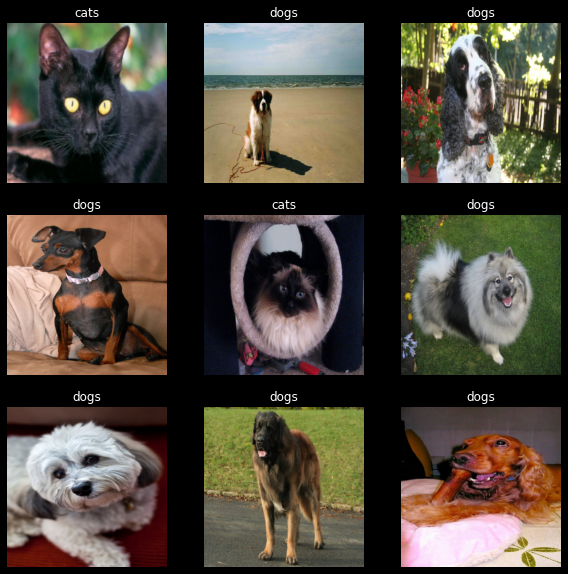

In [10]:
class_names = list(train_dataset.dataset.class_to_idx.keys())

fig = plt.figure(figsize=(10, 10))
for images, labels in train_dataloader:
    for i in range(9):        
        ax = plt.subplot(3, 3, i + 1)
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        plt.imshow(img)
        plt.title(class_names[int(labels[i].item())])
        plt.axis("off")
    break
        

plt.show()


## Modelling

We create a simple model consisting of:
- 3 convolution blocks with a max pooling operation after
- 1 linear layer with 128 units 
- 1 linear layer which outputs one binary value (dog or cat)


In [7]:
import torch.nn as nn
import torch.nn.functional as F


class BinaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 81 * 4, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

def train_loop(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader.dataset)
    accuracy = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        #FORWARD PASS
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()
        accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    accuracy /= size
    history['train_loss'].append(loss)
    history['train_accuracy'].append(accuracy)
    return loss, accuracy


def test_loop(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            
            loss += loss_fn(pred, y).item()
            accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy /= size

    history['test_loss'].append(loss)
    history['test_accuracy'].append(accuracy)
    return loss, accuracy

We train this model for 10 epochs with an Adam optimizer with default lr (1e-3) and a BCELoss (Binary Cross Entropy Loss).

In [8]:
model = BinaryNet().to(device)
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())


epochs = 10
history = {
    'train_loss':[],
    'train_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, history)
    test_loop(test_dataloader, model, loss_fn, history)

01:04 Elapsed | 100% done |██████████| 10/10 [00:00 remaining |  6.49s/epoch]


Finally, we visualize the training and validation accuracy and loss. 

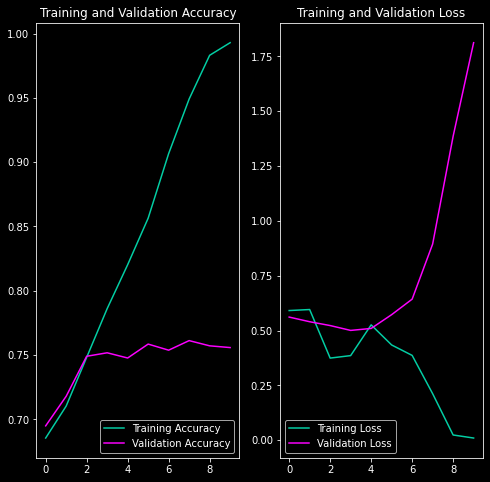

In [9]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='#03CEA4')
plt.plot(epochs_range, history['test_accuracy'], label='Validation Accuracy', color='#fc00ff')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='#03CEA4')
plt.plot(epochs_range, history['test_loss'], label='Validation Loss', color='#fc00ff')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()


The validation loss increases after the 5th epoch or so. This is because the model is over-fitting to the training data.

In [11]:
import pickle

pickle.dump(history, open(pathlib.Path()/'data'/'10-pet-classif-basic.pkl', 'wb'))